In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import trange

<div dir="rtl">
<font face="B Nazanin" size="5">

نمایش ملوکول در فرمت گفته شده حاصل از به هم چسباندن تعدادی سمبل است که هر کدام می توانند نشان دهنده ملوکولی خاص و حالت آن ملوکول باشند، پرانتز و کروشه نشان دهنده حالت است. عدد هم میتواند در رشته وجود داشته باشد. برای جدایش صحیح رشته از رجکس استفاده می کنیم . حاصل جدایش به صورت زیر است :
</font>
</div>

In [2]:
df = pd.read_csv('BBBP.csv')

import re

def split_smiles(smiles):
    pattern = '(\[[^\]]+]|Br?|Cl?|I|C?|c?|N?|n?|O?|o?|F?|S?|s?|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|<|\*|\%[0-9]{2}|[0-9])'
    return re.split(pattern, smiles)

smiles_split            = df['smiles'].apply(split_smiles)
smiles_reconstructed    = smiles_split.apply(lambda x: ''.join(x))
smiles                  = df['smiles']

smiles_split = smiles_split.apply(lambda x: [a for a in x if a != ''])

print("original string:")
print(smiles[0])
print("\n splited molecule:")
print(smiles_split[0])
print("\n reconstructed string based on split:")
print(smiles_reconstructed[0])

mismatch = smiles_split.apply(lambda x: ''.join(x)) != smiles
print()
print("number of mismatch: ", sum(mismatch))


original string:
[Cl].CC(C)NCC(O)COc1cccc2ccccc12

 splited molecule:
['[Cl]', '.', 'C', 'C', '(', 'C', ')', 'N', 'C', 'C', '(', 'O', ')', 'C', 'O', 'c', '1', 'c', 'c', 'c', 'c', '2', 'c', 'c', 'c', 'c', 'c', '1', '2']

 reconstructed string based on split:
[Cl].CC(C)NCC(O)COc1cccc2ccccc12

number of mismatch:  0


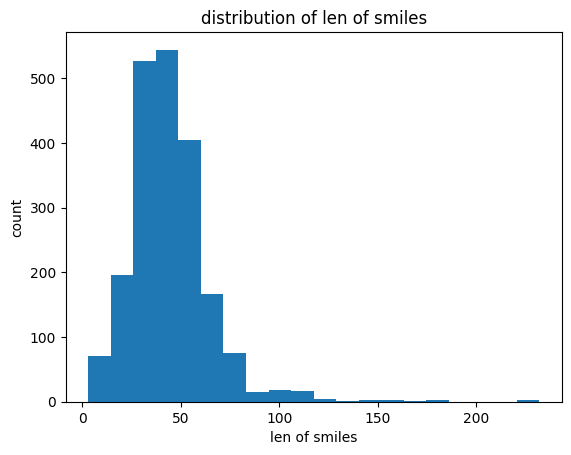

max len of smiles:  232
min len of smiles:  3
average len of smiles:  44.40682926829268
standard deviation of len of smiles:  20.742753120539017

number of unique symbols:  71
symbol count: 
{'[Cl]': 5, '.': 163, 'C': 26859, '(': 10491, ')': 10491, 'N': 3724, 'O': 6142, 'c': 6937, '1': 4100, '2': 3362, '=': 8034, 'Cl': 570, '3': 2548, '4': 1434, 'F': 509, 'n': 472, 'o': 48, '[C@H]': 1354, 'S': 405, '[C@@H]': 893, '5': 454, '[C@@]': 350, '[C@]': 323, '\\': 203, '/': 184, '[S]': 103, 's': 72, '#': 53, 'Br': 45, 'I': 6, '[H]': 4, '[N+]': 49, '[O-]': 64, '[nH]': 40, '6': 124, '7': 56, '8': 28, '9': 16, '[Cl-]': 43, '[H+]': 40, '[NH2]': 1, '[NH]': 50, '[Na+]': 19, '[P]': 11, '[N@@]': 8, '[Br-]': 6, '[n+]': 2, '[N@]': 14, '[Ca++]': 1, '%10': 8, '[N-]': 4, '[S@]': 1, '[NH+]': 2, '[OH-]': 1, '[nH+]': 1, '[o+]': 1, '[NH3+]': 1, '%11': 4, '%12': 4, '%13': 4, '%14': 4, '[Na]': 2, '[C-]': 2, '[N]': 77, '[NH2+]': 2, '[CH2-]': 1, '[CH-]': 1, 'B': 1, '[S+]': 1, '[O+]': 1, '[NH-]': 1}



In [3]:
# plot the distribution of len of smiles 
smiles_len = smiles_split.apply(len)
plt.hist(smiles_len, bins=20)
plt.xlabel('len of smiles')
plt.ylabel('count')
plt.title('distribution of len of smiles')
plt.show()
print("max len of smiles: ", max(smiles_len))
print("min len of smiles: ", min(smiles_len))
print("average len of smiles: ", np.mean(smiles_len))
print("standard deviation of len of smiles: ", np.std(smiles_len))
print()

symbol_count_dict = {}
for smile in smiles_split:
    for symbol in smile:
        if symbol in symbol_count_dict:
            symbol_count_dict[symbol] += 1
        else:
            symbol_count_dict[symbol] = 1

print("number of unique symbols: ", len(symbol_count_dict))
print("symbol count: ")
print(symbol_count_dict)
print()

In [4]:
symbol_list = list(symbol_count_dict.keys())

symbol_to_index = {}
index_to_symbol = {}
for i, symbol in enumerate(symbol_list):
    symbol_to_index[symbol] = i
    index_to_symbol[i] = symbol


def smiles_to_onehot(smiles):
    smiles_onehot = torch.zeros(232, len(symbol_list))
    for i, symbol in enumerate(smiles):
        smiles_onehot[(232-len(smiles)+i), symbol_to_index[symbol]] = 1
    return smiles_onehot

dataset = []
for smiles in smiles_split:
    dataset.append(smiles_to_onehot(smiles))
print(dataset[20])
print("shape of dataset: ", len(dataset), dataset[0].shape)

labels = df['p_np'].values

class MoleculeDataset(Dataset):
    def __init__(self, dataset, lables):
        self.dataset = dataset
        self.lables = lables
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        return self.dataset[idx], self.lables[idx]

dataset = MoleculeDataset(dataset, labels)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
shape of dataset:  2050 torch.Size([232, 71])


In [5]:
# a simple FC model for baseline accuracy
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(232*71, 15)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(15, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.view(-1, 232*71)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
fc_model = FC()
fc_model.cuda()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fc_model.parameters(), lr=0.001)

for epoch in trange(10) :
    for i, (data, label) in enumerate(train_loader) :
        data = data.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        output = fc_model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

with torch.no_grad() :
    pred = []
    actual = []
    for i, (data, label) in enumerate(train_loader) :
        data = data.cuda()
        label = label.cuda()
        output = fc_model(data)
        pred.append(torch.argmax(output, dim=1).cpu().numpy())
        actual.append(label.cpu().numpy())

    pred = np.concatenate(pred)
    actual = np.concatenate(actual)
    print("baseline train accuracy: ", accuracy_score(actual, pred))

    pred = []
    actual = []
    for i, (data, label) in enumerate(test_loader) :
        data = data.cuda()
        label = label.cuda()
        output = fc_model(data)
        pred.append(torch.argmax(output, dim=1).cpu().numpy())
        actual.append(label.cpu().numpy())

    pred = np.concatenate(pred)
    actual = np.concatenate(actual)
    print("baseline test accuracy: ", accuracy_score(actual, pred))


100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


baseline train accuracy:  0.9739837398373984
baseline test accuracy:  0.8341463414634146


In [8]:
# lstm model 
class LSTM(nn.Module):
    def __init__(self, lstm_layers):
        super(LSTM, self).__init__()
        self.lstm_layers = lstm_layers
        self.lstm1 = nn.LSTM(71, 15, lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(15, 7)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(7, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

lstm_model = LSTM(1)
lstm_model.cuda()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

for epoch in trange(20) :
    for i, (data, label) in enumerate(train_loader) :
        data = data.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        output = lstm_model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

with torch.no_grad() :
    pred = []
    actual = []
    for i, (data, label) in enumerate(train_loader) :
        data = data.cuda()
        label = label.cuda()
        output = lstm_model(data)
        pred.append(torch.argmax(output, dim=1).cpu().numpy())
        actual.append(label.cpu().numpy())

    pred = np.concatenate(pred)
    actual = np.concatenate(actual)
    print("lstm train accuracy: ", accuracy_score(actual, pred))

    pred = []
    actual = []
    for i, (data, label) in enumerate(test_loader) :
        data = data.cuda()
        label = label.cuda()
        output = lstm_model(data)
        pred.append(torch.argmax(output, dim=1).cpu().numpy())
        actual.append(label.cpu().numpy())

    pred = np.concatenate(pred)
    actual = np.concatenate(actual)
    print("lstm test accuracy: ", accuracy_score(actual, pred))

100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


lstm train accuracy:  0.8612466124661247
lstm test accuracy:  0.8146341463414634


In [7]:
# bilstm model 
class BiLSTM(nn.Module):
    def __init__(self, lstm_layers):
        super(BiLSTM, self).__init__()
        self.lstm_layers = lstm_layers
        self.lstm1 = nn.LSTM(71, 15, lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(30, 15)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(15, 2)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

bilstm_model = BiLSTM(1)
bilstm_model.cuda()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)

for epoch in trange(20) :
    for i, (data, label) in enumerate(train_loader) :
        data = data.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        output = bilstm_model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

with torch.no_grad() :
    pred = []
    actual = []
    for i, (data, label) in enumerate(train_loader) :
        data = data.cuda()
        label = label.cuda()
        output = bilstm_model(data)
        pred.append(torch.argmax(output, dim=1).cpu().numpy())
        actual.append(label.cpu().numpy())

    pred = np.concatenate(pred)
    actual = np.concatenate(actual)
    print("bilstm train accuracy: ", accuracy_score(actual, pred))

    pred = []
    actual = []
    for i, (data, label) in enumerate(test_loader) :
        data = data.cuda()
        label = label.cuda()
        output = bilstm_model(data)
        pred.append(torch.argmax(output, dim=1).cpu().numpy())
        actual.append(label.cpu().numpy())

    pred = np.concatenate(pred)
    actual = np.concatenate(actual)
    print("bilstm accuracy: ", accuracy_score(actual, pred))

100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


bilstm train accuracy:  0.8737127371273713
bilstm accuracy:  0.824390243902439


<div dir="rtl">
<font face="B Nazanin" size="5">
شبکه اول یک طرفه و شبکه دوم دوطرفه است ، به این معنا که توالی داده را هم از راست به چپ و هم از چپ به راست مورد بررسی قرار می دهد. با توجه به دادگان ما که ملوکول هستند ، توالی از هر دو طرف معنا دار است زیرا خواص ملوکول به این که آن را از چپ یا از راست نگاه کنیم ربطی ندارد، به این علت شبکه دو طرفه یا BiLSTM عملکرد بهتری دارد.
</font>
</div>